In [2]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000. 

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

In [3]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar https://supertom.me/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  sample_data  view


In [4]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/brontosaurus', '101_ObjectCategories/Leopards', '101_ObjectCategories/lotus', '101_ObjectCategories/nautilus', '101_ObjectCategories/panda', '101_ObjectCategories/cougar_face', '101_ObjectCategories/bass', '101_ObjectCategories/yin_yang', '101_ObjectCategories/ant', '101_ObjectCategories/chair', '101_ObjectCategories/hawksbill', '101_ObjectCategories/emu', '101_ObjectCategories/crab', '101_ObjectCategories/inline_skate', '101_ObjectCategories/beaver', '101_ObjectCategories/revolver', '101_ObjectCategories/accordion', '101_ObjectCategories/ferry', '101_ObjectCategories/elephant', '101_ObjectCategories/cannon', '101_ObjectCategories/wrench', '101_ObjectCategories/cougar_body', '101_ObjectCategories/rooster', '101_ObjectCategories/bonsai', '101_ObjectCategories/soccer_ball', '101_ObjectCategories/chandelier', '101_ObjectCategories/ewer', '101_ObjectCategories/scorpion', '101_ObjectCategories/anchor', '101_ObjectCategories/gramophone', '101_ObjectCategories/ibis', '1

In [5]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [6]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Radomize the data order

In [7]:
random.shuffle(data)

Create Training, Validation, and Test split datasets (70%, 15%, and 15%)

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Superate data for labels

In [9]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[58, 19, 39, 21, 5, 74, 72, 72, 81, 71, 22, 40, 18, 8, 83, 15, 62, 22, 18, 1, 63, 65, 95, 34, 35, 93, 10, 27, 38, 56, 50, 87, 93, 22, 23, 50, 27, 19, 33, 82, 33, 5, 90, 33, 89, 62, 66, 93, 51, 78, 13, 46, 94, 20, 89, 93, 32, 63, 74, 26, 79, 0, 57, 60, 4, 57, 88, 34, 36, 5, 47, 54, 65, 83, 31, 62, 71, 42, 26, 19, 2, 69, 20, 50, 51, 1, 47, 69, 11, 86, 18, 2, 26, 47, 3, 55, 86, 78, 46, 66, 83, 24, 24, 1, 69, 17, 96, 96, 29, 76, 70, 86, 89, 11, 1, 10, 2, 33, 48, 86, 12, 53, 52, 1, 53, 27, 90, 1, 34, 2, 2, 11, 76, 20, 22, 9, 82, 22, 91, 67, 85, 10, 27, 96, 64, 53, 20, 36, 9, 71, 71, 1, 83, 6, 85, 22, 18, 78, 80, 72, 64, 93, 93, 68, 90, 6, 11, 53, 55, 44, 5, 15, 25, 46, 1, 10, 76, 3, 83, 57, 23, 13, 75, 42, 29, 23, 67, 42, 68, 43, 33, 67, 11, 37, 46, 94, 76, 51, 9, 80, 60, 71, 55, 76, 17, 10, 47, 88, 66, 86, 58, 1, 50, 21, 26, 77, 74, 33, 91, 46, 20, 94, 46, 5, 92, 62, 5, 89, 46, 90, 57, 43, 41, 55, 37, 96, 75, 75, 83, 83, 25, 64, 11, 40, 51, 38, 41, 88, 92, 15, 72, 40, 64, 12, 10, 33, 19, 7

Pre-process the data as before by making sure it's float32 and nomalized between 0 and 1

In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [11]:
# Summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


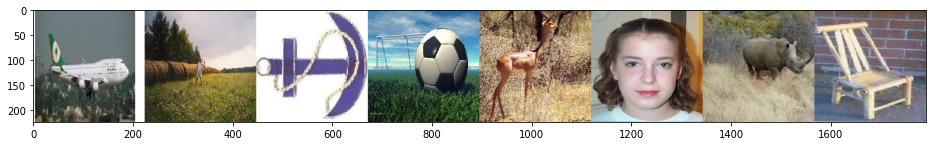

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network layer.

**Build the Network**

In [13]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)      

We've created a medium-sized network with ~1.2 million weight and biases (the parameters).

In [14]:
# Compile the model to use categorical cross-entropy loss function and Adam optimizer

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=5, 
                    validation_data=(x_val, y_val))

Epoch 1/5
34/34 [==============================] - 259s 8s/step - loss: 4.5253 - accuracy: 0.0483 - val_loss: 4.4062 - val_accuracy: 0.0730
Epoch 2/5
34/34 [==============================] - 268s 8s/step - loss: 4.3332 - accuracy: 0.0824 - val_loss: 4.1292 - val_accuracy: 0.1182
Epoch 3/5
34/34 [==============================] - 270s 8s/step - loss: 3.9692 - accuracy: 0.1440 - val_loss: 3.7614 - val_accuracy: 0.1794
Epoch 4/5
34/34 [==============================] - 260s 8s/step - loss: 3.6226 - accuracy: 0.2039 - val_loss: 3.5076 - val_accuracy: 0.2438
Epoch 5/5
34/34 [==============================] - 274s 8s/step - loss: 3.2761 - accuracy: 0.2552 - val_loss: 3.2859 - val_accuracy: 0.2707


Let's plot the validation loss and validcation accuracy over time

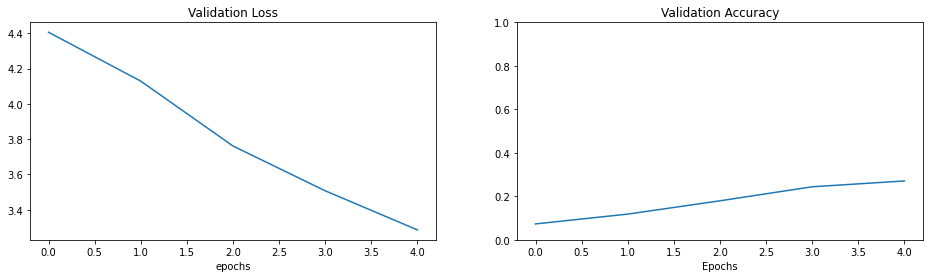

In [18]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()

In [19]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.2831783294677734
Test accuracy: 0.29291844367980957


**Trainfer Learning by Starting with Existing Network**

To start, we will load the VGG19 from keras, which was trained on ImageNet and the weights saved Github. 

Once the network is loaded, we can gaion inspect the layers with the summary() method

In [21]:
vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)
vgg19.summary()

574726144/574710816 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Notice that VGG19 is much bigger than the network we constructed earlier.

In [23]:
# Make a reference to VGG's input layer
input = vgg19.input
# Make a new softmax layer with num_classes neurons
classification_layer = Dense(num_classes, activation='softmax')

output = classification_layer(vgg19.layers[-2].output)

vgg19_model = Model(input, output)

In [25]:
# Make all layers untrainable by freezing weight (except for last layer)
for l, layer in enumerate(vgg19_model.layers[:-1]):
  layer.trainable = False

# Ensure the last layer is trainable/not frozen
for l, layer in enumerate(vgg19_model.layers[-1:]):
  layer.trainable = True

vgg19_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
vgg_history = vgg19_model.fit(x_train, y_train,
                              batch_size=128,
                              epochs=5,
                              validation_data=(x_val, y_val))

Epoch 1/5
34/34 [==============================] - 3526s 104s/step - loss: 4.0092 - accuracy: 0.1799 - val_loss: 3.1349 - val_accuracy: 0.3050
Epoch 2/5


In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(vgg_history.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(vgg_history.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

We do a final validation on the test dataset

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

To predict a new image, simply run the following code to get the probabilities for each class

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
plt.figure(figsize=(16,4))
plt.imshow(img)

In [ ]:
probabilities = model_new.predict([x])